# Data Analyst Entry-Level Job Analysis in Russia on hh.ru: Skills, Salary Trends, and Job Location Insights


* * * 

Import the necessary libraries for the analysis

In [1]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import folium

## Collecting Job Data and Saving it to an Excel File

Using the [API](https://dev.hh.ru/) , we will collect data from the [hh.ru](https://hh.ru/) website for job postings that match the search query "data analyst" within Russia. We will limit our search to job postings that do not require work experience.

We will save the retrieved data into a DataFrame named df, which will contain the following columns:

* Title – job title
* Company – the company that posted the job
* City – the city where the job is located
* Salary – the salary specified in the job posting
* Salary_Gross – indicates whether the salary is before taxes (True) or after taxes (False)
* Salary_Currency – the currency in which the salary is listed
* Key_Skills – key skills listed in the job posting

In [51]:
# Use the API to get job data from hh.ru
url = 'https://api.hh.ru/vacancies'

# Define the request parameters
# - 'text': search query "Аналитик данных OR Data Analyst OR SQL OR RDBMS" 
# - 'search_field': search by job title
# - 'area': search area code (113 for all of Russia)
# - 'per_page': number of job postings per page (maximum 100)
# - 'no_magic': disable automatic vacancy transformation (needed for search accuracy)
# - 'experience': required work experience (no work experience required)
params = {
    'text': 'Аналитик данных OR Data Analyst OR SQL OR RDBMS',
    'search_field': 'name',
    'area': 113,
    'per_page': 100,
    'no_magic': True,
    'experience': 'noExperience'
}

# Define the list of columns to save data
columns = ['Title', 'Company', 'City', 'Salary', 'Salary_Gross', 'Salary_Currency', 'Key_Skills', 'URL']

data = []

# Get data from search result pages
for page in range(20):
    params['page'] = page
    response = requests.get(url, params=params)

    if response.ok:
        vacancies = response.json()['items']
        for vacancy in vacancies:
            # Extract job information
            title = vacancy['name']
            company = vacancy['employer']['name']
            city = vacancy['area']['name']

            # Process salary information
            salary = vacancy.get('salary', {})
            if salary:
                salary_gross = str(salary.get('gross'))
                salary_currency = str(salary.get('currency'))
                if salary.get('from'):
                    salary = str(salary.get('from'))
                else:
                    salary = str(salary.get('to'))
            else:
                salary = 'NaN'
                salary_gross = 'NaN'
                salary_currency = 'NaN'

            # Extract key skills of the vacancy
            url_vacancy = vacancy['alternate_url']
            vacancy_id = url_vacancy.split('/')[-1]
            details_response = requests.get(f'https://api.hh.ru/vacancies/{vacancy_id}')
            if details_response.ok:
                details = details_response.json()
                key_skills = [skill['name'] for skill in details.get('key_skills', [])]
            else:
                key_skills = []

            # Add data to the list
            data.append([title, company, city, salary, salary_gross, salary_currency, key_skills, url_vacancy])

    else:
        print('Error:', response.status_code)

    # Delay before the next request (3 seconds)
    time.sleep(3)

# Create a DataFrame based on the obtained data
df = pd.DataFrame(data, columns=columns)

Let's check the number of rows and columns in the DataFrame df

In [52]:
df.shape

(128, 8)

Let's look at the first 5 rows of the DataFrame df

In [53]:
df.head()

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000,False,RUR,[],https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,[],https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,[MS SQL Server],https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,[MS SQL Server],https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000,False,RUR,[],https://hh.ru/vacancy/106505774


Save the resulting DataFrame df to an Excel file named `hh_project_raw.xlsx.`

In [54]:
df.to_excel('hh_project_raw.xlsx',sheet_name='RawData', index=False)

## Fetching Exchange Rates from the Central Bank of Russia for Today

Import the necessary libraries for web scraping

In [55]:
from bs4 import BeautifulSoup

From the [web page](https://www.cbr.ru/eng/currency_base/daily/) of the Central Bank of Russia, we will obtain the exchange rates for the current day and save them in a list called `currency_list`. The exchange rates will be necessary for standardizing salary information in the job postings

In [56]:
currency_list = []
try:
    url = 'https://www.cbr.ru/eng/currency_base/daily/'
    source = requests.get(url)
    source.raise_for_status()

    soup = BeautifulSoup(source.text, 'html.parser')
    currencies = soup.find('tbody').find_all('tr')
    for cur in currencies:
        currency = cur.find_all('td')
        currency_list.append(currency)
except Exception as e:
    print(e)


**For convenience, we will process the data:**
1. Create a DataFrame `df_currency` from the `currency_list` data
2. Remove unnecessary columns from the `df_currency` DataFrame
3. Remove the characters `[` and `]` from the df_currency DataFrame
4. Rename the columns to `Currency`, `Unit`, and `In_RUR`
5. Remove empty rows
6. Update the row indices
7. Convert `Unit` and `In_RUR` to float type
8. Create a new column `Cur_RUR` by dividing the `In_RUR` column by the `Unit` column - determine the cost in rubles of 1 unit of foreign currency
9. Remove the `Unit` and `In_RUR` columns

As a result, the `df_currency` DataFrame will contain 2 columns: `Currency` - currency code and `Cur_RUR` - cost of 1 unit of currency in rubles

In [57]:
df_currency = pd.DataFrame(currency_list)
df_currency = df_currency.drop(df_currency.columns[[0, 3]], axis=1)
df_currency = df_currency.apply(lambda x: x.str.join('').str.strip('[]'))
df_currency.columns = ['Currency', 'Unit', 'In_RUR']
df_currency.dropna(inplace=True)
df_currency.reset_index(inplace=True, drop=True)
df_currency[['Unit', 'In_RUR']] = df_currency[['Unit', 'In_RUR']].astype(float)
df_currency['Cur_RUR'] = df_currency['In_RUR']/df_currency['Unit']
df_currency = df_currency.drop(['Unit', 'In_RUR'], axis=1)
df_currency.head()

,Currency,Cur_RUR
0,AUD,60.308300
1,AZN,52.767300
2,AMD,0.231615
3,BYN,28.336400
4,BGN,50.681000


In [58]:
df_currency.dtypes

Currency     object
Cur_RUR     float64
dtype: object

## Data cleaning and wrangling

Read the saved Excel file `hh_project_raw.xlsx` and write it to a DataFrame called `raw_data`

In [59]:
raw_data = pd.read_excel('hh_project_raw.xlsx')
raw_data

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,[],https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,[],https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,['MS SQL Server'],https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,['MS SQL Server'],https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,[],https://hh.ru/vacancy/106505774
...,...,...,...,...,...,...,...,...
123,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"['SQL', 'Power BI', 'Python']",https://hh.ru/vacancy/106379811
124,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"['Анализ данных', 'Классическое машинное обуче...",https://hh.ru/vacancy/106465350
125,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"['Грамотность', 'Обучение', 'Индивидуальное об...",https://hh.ru/vacancy/106274294
126,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",https://hh.ru/vacancy/106007630


Data Transformation in Columns

Remove the characters `[`, `]`, and `'` from the `Key_Skills` column

In [66]:
raw_data['Key_Skills'] = raw_data['Key_Skills'].str.replace("[\[\]']", "", regex=True)
raw_data.head()


,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774


Standardize the data in the `City` column - discard the part of the string in city names. \
For example, from Киров (Кировская область) we get Киров

In [65]:
raw_data['City'] = raw_data['City'].str.split(' \(').str[0]
raw_data['City'] 

0               Москва
1               Москва
2      Санкт-Петербург
3          Новосибирск
4               Москва
            ...       
123           Тольятти
124           Тольятти
125            Колпино
126            Колпино
127           Тольятти
Name: City, Length: 128, dtype: object

Exclude senior/lead positions to keep only junior-level positions. \
 Save the updated data to a DataFrame called `jun_analyst_data`

In [165]:
jun_analyst_data = raw_data[~raw_data['Title'].str.contains('senior|lead|старший|ведущий|главный|руководитель|начальник', case=False)]
jun_analyst_data

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774
...,...,...,...,...,...,...,...,...
123,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811
124,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350
125,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294
126,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630


Exclude developer positions to keep only analyst positions. \
Update DataFrame `jun_analyst_data`

In [168]:
jun_analyst_data= jun_analyst_data[~jun_analyst_data['Title'].str.contains('программист|developer|разработчик', case=False)]
jun_analyst_data

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774
...,...,...,...,...,...,...,...,...
123,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811
124,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350
125,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294
126,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630


Reset the index in `the analyst_cleaned` DataFrame

In [170]:
jun_analyst_data.reset_index(inplace=True, drop=True)
jun_analyst_data

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774
...,...,...,...,...,...,...,...,...
102,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811
103,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350
104,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294
105,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630


Create a copy of the `jun_analyst_data` DataFrame and save it to a DataFrame called `analyst_cleaned`

In [171]:
analyst_cleaned = jun_analyst_data.copy()
analyst_cleaned.head()

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774


Since salaries in job postings are listed differently (before or after taxes), we will standardize all salary values to 'after taxes'. \
To do this, multiply the salary 'before taxes' (where the Salary_Gross column value is True) by 0.87 (reduce by 13% tax). \
If the salary is already specified after taxes, leave the value unchanged. \
Save this value in the Salary_Net column

In [172]:
analyst_cleaned['Salary_Net'] = analyst_cleaned['Salary'].where(
    (analyst_cleaned['Salary_Gross']==False) | (analyst_cleaned['Salary_Gross']=='False'), 
    analyst_cleaned['Salary']*0.87)
analyst_cleaned

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL,Salary_Net
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658,80000.0
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804,NaN
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922,NaN
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921,NaN
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774,100000.0
...,...,...,...,...,...,...,...,...,...
102,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811,NaN
103,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350,87000.0
104,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294,120000.0
105,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630,69600.0


**Update the `analyst_cleaned` DataFrame - use the `merge` function to join the `Currency` and `Cur_RUR` columns from the `df_currency` DataFrame. This will allow us to convert non-ruble salaries in job postings (if any) in the future.**

In [173]:
analyst_cleaned = analyst_cleaned.merge(df_currency, how = 'left', left_on= 'Salary_Currency', right_on='Currency')
analyst_cleaned

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL,Salary_Net,Currency,Cur_RUR
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658,80000.0,NaN,NaN
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804,NaN,NaN,NaN
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922,NaN,NaN,NaN
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921,NaN,NaN,NaN
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774,100000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
102,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811,NaN,NaN,NaN
103,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350,87000.0,NaN,NaN
104,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294,120000.0,NaN,NaN
105,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630,69600.0,NaN,NaN


Update the `analyst_cleaned` DataFrame - convert non-ruble salaries to Russian rubles: add a column `Salary_Net_RUR`, which will be equal to `Salary_Net` * `Cur_RUR` for salaries in foreign currencies. Leave salaries initially specified in rubles unchanged.

In [174]:
analyst_cleaned['Salary_Net_RUR'] = (analyst_cleaned['Salary_Net']*analyst_cleaned['Cur_RUR']).where(
    analyst_cleaned['Cur_RUR'].notna(), analyst_cleaned['Salary_Net'])
analyst_cleaned

,Title,Company,City,Salary,Salary_Gross,Salary_Currency,Key_Skills,URL,Salary_Net,Currency,Cur_RUR,Salary_Net_RUR
0,Junior data analyst,"Эксмо, издательство",Москва,80000.0,False,RUR,,https://hh.ru/vacancy/106670658,80000.0,NaN,NaN,80000.0
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,NaN,NaN,NaN,,https://hh.ru/vacancy/106552804,NaN,NaN,NaN,NaN
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759922,NaN,NaN,NaN,NaN
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,NaN,NaN,NaN,MS SQL Server,https://hh.ru/vacancy/106759921,NaN,NaN,NaN,NaN
4,Аналитик данных (Python),Авангард,Москва,100000.0,False,RUR,,https://hh.ru/vacancy/106505774,100000.0,NaN,NaN,100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102,Data Analyst,Aston,Тольятти,NaN,NaN,NaN,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811,NaN,NaN,NaN,NaN
103,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,100000.0,True,RUR,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350,87000.0,NaN,NaN,87000.0
104,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,120000.0,False,RUR,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294,120000.0,NaN,NaN,120000.0
105,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,80000.0,True,RUR,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630,69600.0,NaN,NaN,69600.0


Remove the columns `Salary`, `Salary_Gross`, `Salary_Currency`, `Salary_Net`, `Currency`, and `Cur_RUR` from the `analyst_cleaned` DataFrame.

In [175]:
analyst_cleaned = analyst_cleaned.drop(columns=['Salary', 'Salary_Gross', 'Salary_Currency', 'Salary_Net', 'Currency', 'Cur_RUR'])
analyst_cleaned

,Title,Company,City,Key_Skills,URL,Salary_Net_RUR
0,Junior data analyst,"Эксмо, издательство",Москва,,https://hh.ru/vacancy/106670658,80000.0
1,Стажёр аналитик баз данных,Лаборатория Касперского,Москва,,https://hh.ru/vacancy/106552804,NaN
2,Стажер-аналитик SQL,АЛРОСА,Санкт-Петербург,MS SQL Server,https://hh.ru/vacancy/106759922,NaN
3,Стажер-аналитик SQL,АЛРОСА,Новосибирск,MS SQL Server,https://hh.ru/vacancy/106759921,NaN
4,Аналитик данных (Python),Авангард,Москва,,https://hh.ru/vacancy/106505774,100000.0
...,...,...,...,...,...,...
102,Data Analyst,Aston,Тольятти,"SQL, Power BI, Python",https://hh.ru/vacancy/106379811,NaN
103,Дата аналитик/аналитик данных (ученик),Aston,Тольятти,"Анализ данных, Классическое машинное обучение,...",https://hh.ru/vacancy/106465350,87000.0
104,Преподаватель компьютерных курсов для взрослых...,Компьютерная Академия Top,Колпино,"Грамотность, Обучение, Индивидуальное обучение...",https://hh.ru/vacancy/106274294,120000.0
105,"Преподаватель компьютерных курсов (Python, MS ...",Компьютерная Академия Top,Колпино,"Пользователь ПК, Грамотная речь, Работа в кома...",https://hh.ru/vacancy/106007630,69600.0


Save the `analyst_cleaned` DataFrame to an Excel file named `hh_project_cleaned.xlsx`.

In [176]:
analyst_cleaned.to_excel('hh_project_cleaned.xlsx', index=False)

## VISUALIZATION

For data visualization, transform the `analyst_cleaned` DataFrame by removing the columns `Company` and `URL`.

In [177]:
analyst_cleaned = analyst_cleaned.drop(columns=['Company', 'URL'])
analyst_cleaned.head()

,Title,City,Key_Skills,Salary_Net_RUR
0,Junior data analyst,Москва,,80000.0
1,Стажёр аналитик баз данных,Москва,,NaN
2,Стажер-аналитик SQL,Санкт-Петербург,MS SQL Server,NaN
3,Стажер-аналитик SQL,Новосибирск,MS SQL Server,NaN
4,Аналитик данных (Python),Москва,,100000.0


### 1. Distribution of Job Postings by City on the Map

Create a DataFrame `count_vacancies_by_city` containing information about cities and the number of job postings in each city.

In [178]:
count_vacancies_by_city = pd.DataFrame(analyst_cleaned.groupby('City').size(), columns=['Total_Vacancies'])
count_vacancies_by_city.sort_values(by='Total_Vacancies', ascending=False, inplace=True)
count_vacancies_by_city.reset_index(inplace=True)
count_vacancies_by_city.head(10)

,City,Total_Vacancies
0,Москва,41
1,Санкт-Петербург,11
2,Владивосток,4
3,Нижний Новгород,4
4,Екатеринбург,4
5,Тольятти,3
6,Самара,3
7,Красноярск,3
8,Краснодар,2
9,Колпино,2


Load city coordinate data from the Excel file `hh_project_russian_cities_towns_geo.xlsx` into a DataFrame called `city_geo`.

In [179]:
city_geo = pd.read_excel('hh_project_russian_cities_towns_geo.xlsx', sheet_name='Лист 1')
city_geo

,Название города,Регион,Округ,Широта,Долгота
0,Гагарин,Смоленская область,Центральный федеральный округ,55.550911,35.014992
1,Бабаево,Вологодская область,Северо-Западный федеральный округ,59.385330,35.950722
2,Багаевский,Ростовская область,Южный федеральный округ,47.266800,40.407749
3,Гаврилов-ям,Ярославская область,Центральный федеральный округ,57.302120,39.856800
4,Абакан,Республика Хакасия,Сибирский федеральный округ,53.729172,91.461189
...,...,...,...,...,...
707,Вязовая,Челябинская область,Уральский федеральный округ,54.906101,58.374310
708,Каспийск,Республика Дагестан,Северо-Кавказский федеральный округ,42.882751,47.638248
709,Яхрома,Московская область,Центральный федеральный округ,56.294109,37.484669
710,Апрелевка,Московская область,Центральный федеральный округ,55.545300,37.061920


Merge the `count_vacancies_by_city` and `city_geo` DataFrames to obtain city data with corresponding coordinates. Clean the data by removing rows without coordinates and unnecessary columns. Rename the columns `Широта` and `Долгота` to `Lat` and `Lon`, respectively.

In [180]:
count_vacancies_by_city_geo = pd.merge(left=count_vacancies_by_city,
                                       right=city_geo,
                                       how='left',
                                       left_on='City',
                                       right_on='Название города',
                                       copy=True)
#count_vacancies_by_city_geo[count_vacancies_by_city_geo['Широта'].isna()]
count_vacancies_by_city_geo.dropna(inplace=True)
count_vacancies_by_city_geo = count_vacancies_by_city_geo.drop(columns=['Название города', 'Регион', 'Округ'])
count_vacancies_by_city_geo.rename(columns={'Широта' : 'Lat', 'Долгота' : 'Lon'}, inplace=True)
#count_vacancies_by_city_geo.shape
count_vacancies_by_city_geo.head()

,City,Total_Vacancies,Lat,Lon
0,Москва,41,55.755787,37.617634
1,Санкт-Петербург,11,59.939037,30.315784
2,Владивосток,4,43.130692,131.923828
3,Нижний Новгород,4,56.329918,44.009193
4,Екатеринбург,4,56.837814,60.596844


After preparing the data, use the Folium library to create an interactive world map.

In the code block:
1. Create a map object and set the initial coordinates and zoom level.
2. For each city in the `count_vacancies_by_city_geo` DataFrame, create a marker on the map indicating its coordinates, number of job postings, and city name.
3. Add each marker to the map.

This will result in a world map visualization where each marker represents a city and the number of job postings there.

In [181]:
mapping = folium.Map(location=[55.755787, 37.617634], zoom_start=5)
# Add markers to the map for each city
#marker_cluster = MarkerCluster().add_to(mapping)

for index, row in count_vacancies_by_city_geo.iterrows():
    city = row['City']
    count = row['Total_Vacancies']
    latitude = row['Lat']
    longitude = row['Lon']
    
    marker = folium.Marker(location=[latitude, longitude], popup=f"{city}: {count} vacancies")
    marker.add_to(mapping)
mapping

### 2. Analysis of Technical Skill Popularity in Data Analyst Job Postings

For analyzing the popularity of technical skills in data analyst job postings, group the most important skills into four categories:

1. **Excel**: Skills related to working with MS Excel.
2. **SQL**: Skills related to working with various SQL DBMS.
3. **Python**: Skills related to working with the Python programming language and Python libraries.
4. **Visualization**: Skills related to working with data visualization software and creating dashboards.

Store the keywords used for categorizing skills in the variables `exc_skills`, `sql_skills`, `pyt_skills`, and `vis_skills` for each category.

In [182]:
exc_skills = 'excel|ВПР|сводн.*таблиц'
sql_skills = 'sql|oracle|db|бд|Qlik.*House'
pyt_skills = 'python|pandas|numpy|plotly|matplotlib|seaborn'
vis_skills = 'dash|даш|tableau|power.*bi|looker|google.*data.*studio|Zoho|Qlik.*Sense'

Count the number of job postings that include skills from each category and save the results in a DataFrame called `group_counts_df`.

In [183]:
group_counts_df = pd.DataFrame({
    'Group_skill': ['Excel', 'SQL', 'Python', 'Visualization'],
    'Counts': [
        len(analyst_cleaned[analyst_cleaned['Key_Skills'].str.contains(exc_skills, case=False, regex=True)]),
        len(analyst_cleaned[analyst_cleaned['Key_Skills'].str.contains(sql_skills, case=False, regex=True)]),
        len(analyst_cleaned[analyst_cleaned['Key_Skills'].str.contains(pyt_skills, case=False, regex=True)]),
        len(analyst_cleaned[analyst_cleaned['Key_Skills'].str.contains(vis_skills, case=False, regex=True)])
    ]
})
group_counts_df

,Group_skill,Counts
0,Excel,14
1,SQL,44
2,Python,31
3,Visualization,21


Add a column `%_of_vacancies` to the `group_counts_df` DataFrame. \
The value of `%_of_vacancies` is calculated as `'Counts'` divided by the length of `analyst_cleaned`, multiplied by 100.

In [184]:
group_counts_df['%_of_vacancies'] = group_counts_df['Counts']/len(analyst_cleaned)*100
group_counts_df = group_counts_df.round(0)
group_counts_df

,Group_skill,Counts,%_of_vacancies
0,Excel,14,13.0
1,SQL,44,41.0
2,Python,31,29.0
3,Visualization,21,20.0


Create a horizontal bar chart, sorting the data in descending order of skill mention frequency in the selected job postings.

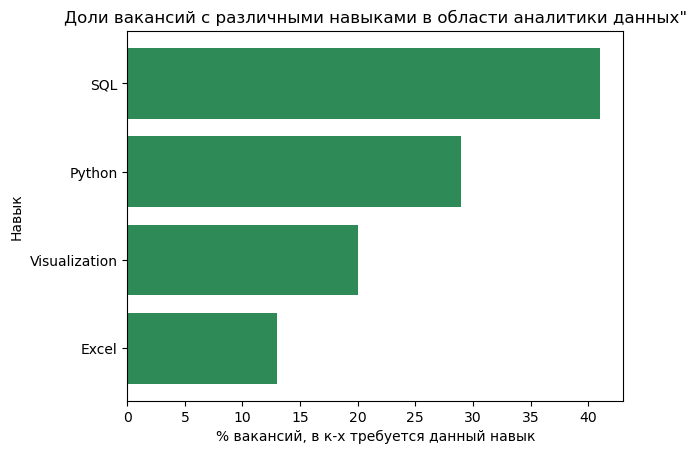

In [185]:
group_counts_df = group_counts_df.sort_values(by='Counts', ascending=True)

plt.barh(group_counts_df['Group_skill'], group_counts_df['%_of_vacancies'], color='seagreen')

plt.xlabel('% вакансий, в к-х требуется данный навык')
plt.ylabel('Навык')
plt.title('Доли вакансий с различными навыками в области аналитики данных"')

plt.show()


The chart clearly shows the differences in skill popularity among data analysts, allowing an easy comparison of the frequency of each skill mention.

The results help students and educators understand which skills are most in demand in the job market for data analysts. SQL and Python are the most common and important skills, highlighting the need for strong proficiency in databases and spreadsheets.

Based on this analysis, students and educators should consider the importance of honing widely demanded skills like SQL. At the same time, attention should be given to enhancing programming skills in Python and data visualization, as these skills can provide a competitive edge in the job market.

This analysis allows for a more informed approach to choosing educational programs, courses, and self-study, focusing on the skills most in demand for data analysts.

### 3. Analysis of Salary Data Across Different Cities: Average and Median Salary Chart

Create a DataFrame `analyst_salary` as a copy of the `analyst_cleaned` DataFrame, excluding rows with empty salary values. \
Remove unnecessary columns and update the row indices.

In [193]:
analyst_salary = analyst_cleaned.copy().dropna(subset=['Salary_Net_RUR'])
analyst_salary.drop(columns=['Key_Skills', 'Title'], inplace=True)
analyst_salary.reset_index(drop=True, inplace=True)
analyst_salary.head()


,City,Salary_Net_RUR
0,Москва,80000.0
1,Москва,100000.0
2,Москва,134556.6
3,Санкт-Петербург,30000.0
4,Назрань,10000.0


Check the data types of the columns in the `analyst_salary` DataFrame.

In [187]:
analyst_salary.dtypes

City               object
Salary_Net_RUR    float64
dtype: object

Analysis of Key Metrics:

In [188]:
analyst_salary.describe()

,Salary_Net_RUR
count,60.000000
mean,66148.157133
std,24660.826662
min,1000.000000
25%,53000.000000
50%,69800.000000
75%,80010.000000
max,134556.600000


The table below contains key statistical metrics for the salaries of selected entry-level data analyst job postings:
* **count** - total number of job postings with specified salaries 
* **mean** - average salary across job postings
* **min** - minimum salary
* **25%** - lower quartile (25% of job postings have salaries below this value)
* **50%** - median salary
* **75%** - upper quartile (25% of job postings have salaries above this value)
* **max** - maximum salary

These data provide an overview of salary distribution among the selected job postings and can be useful for analyzing the job market for entry-level data analysts.

Calculate key metrics (count, average, median, maximum, and minimum) for each city individually. Save the top 10 cities by the number of job postings, in descending order, to a DataFrame called `salary_bycity_top10`.

In [189]:
salary_bycity = analyst_salary.groupby('City').agg({'Salary_Net_RUR': ['count','mean', 'median', 'max', 'min']})
salary_bycity.sort_values(by=[('Salary_Net_RUR', 'count')], ascending=False, inplace=True)
salary_bycity.columns = salary_bycity.columns.droplevel(0)
salary_bycity.reset_index(inplace=True)
salary_bycity_top10 = salary_bycity.head(10)
salary_bycity_top10

,City,count,mean,median,max,min
0,Москва,17,75864.084000,70000.0,134556.6,40000.0
1,Санкт-Петербург,6,61166.666667,55000.0,100000.0,30000.0
2,Красноярск,3,52863.333333,50000.0,70000.0,38590.0
3,Владивосток,3,66666.666667,70000.0,70000.0,60000.0
4,Екатеринбург,3,51333.333333,54000.0,60000.0,40000.0
5,Самара,3,82633.333333,87000.0,100000.0,60900.0
6,Тольятти,2,93500.000000,93500.0,100000.0,87000.0
7,Кемерово,2,44360.000000,44360.0,48720.0,40000.0
8,Колпино,2,94800.000000,94800.0,120000.0,69600.0
9,Богучаны,2,70000.000000,70000.0,70000.0,70000.0


Create a chart displaying the median and average salaries for the cities in the `salary_bycity_top10` DataFrame.

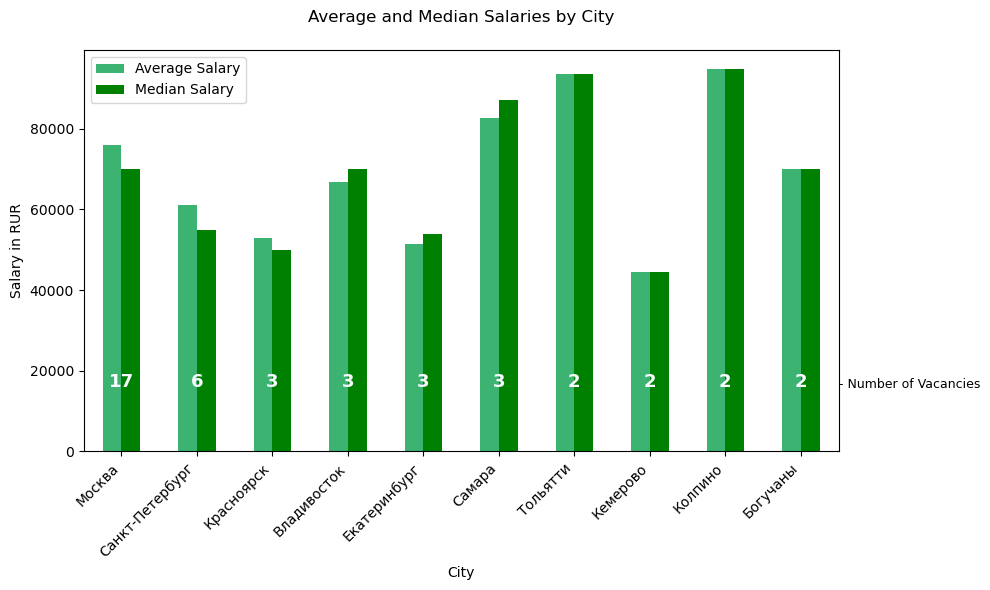

In [190]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart for mean and median salaries
salary_bycity_top10.plot.bar(x='City', y=['mean', 'median'], ax=ax, color=['mediumseagreen', 'green'])
ax.set_ylabel('Salary in RUR')
ax.legend(['Average Salary', 'Median Salary'])

# Set the x-axis label
ax.set_xlabel('City')

# Rotate the x-axis labels for better readability
ax.set_xticklabels(salary_bycity_top10['City'], rotation=45, ha='right')

# Add the count values as annotations
count_height = 15000
for i, count in enumerate(salary_bycity_top10['count']):
    ax.text(i, count_height, str(count), ha='center', va='bottom', color='ghostwhite', fontsize=13, fontweight='bold')

# Add explanation as text elements
explanation = ['- Number of Vacancies']
explanation_pos = [9.5]
for i, explanation_text in enumerate(explanation):
    ax.text(explanation_pos[i], count_height, explanation_text, ha='left', va='bottom', color='black', fontsize=9)

# Set the title
plt.title('Average and Median Salaries by City', pad=20)

plt.tight_layout()
plt.show()


The chart shows that salary metrics for entry-level data analysts vary across Russian cities. For example, Moscow (Москва) offers higher average and median salaries. It is important to note that in Kolpino (Колпино), average and median salaries are also higher, but the number of job postings is limited.

When choosing a city for work, it is crucial to consider both salary conditions and employment opportunities in the selected region.

### 4. Analysis of Salary Distribution in Job Postings Using a Histogram

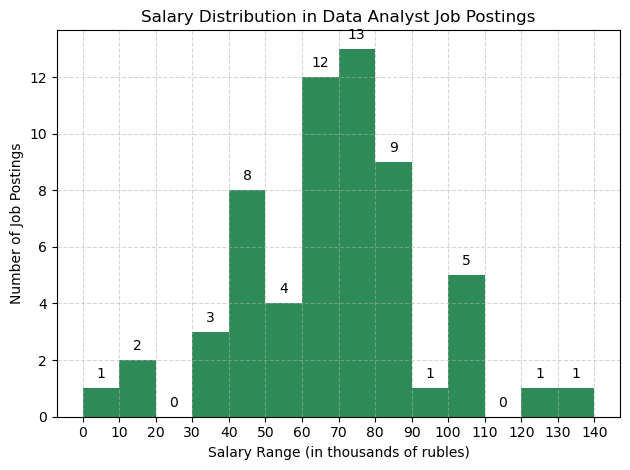

In [197]:
import numpy as np
import matplotlib.ticker as ticker

# Set the desired step size
step_size = 10000

# Compute the range of values for the bins
bin_min = np.floor(analyst_salary['Salary_Net_RUR'].min() / step_size) * step_size
bin_max = np.ceil(analyst_salary['Salary_Net_RUR'].max() / step_size) * step_size

# Generate the bin edges with the specified step size
bins = np.arange(bin_min, bin_max + step_size, step_size)

# Plot the histogram
counts, bins, _ = plt.hist(analyst_salary['Salary_Net_RUR'], bins=bins, color='seagreen')

# Customize the chart
plt.xlabel('Salary Range (in thousands of rubles)')
plt.ylabel('Number of Job Postings')
plt.title('Salary Distribution in Data Analyst Job Postings')
plt.grid(True, linestyle='--', alpha=0.5)

# Format x-tick labels in thousands
formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x * 1e-3))
plt.gca().xaxis.set_major_formatter(formatter)

# Set x-ticks as bin edges
plt.xticks(bins)

# Add annotations for each column
for count, bin_val in zip(counts, bins[:-1]):
    plt.annotate(int(count), xy=(bin_val, count), xytext=(bin_val+5000, count+0.25),
                 ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


The results of the graph show that the salary distribution for data analyst job postings is presented in bins. The most typical and frequently occurring salary range is between 30,000 and 90,000 rubles. This range covers the vast majority of the job postings and can be considered the primary salary offer for this profession.

There is a small number of job postings with salaries below 20,000 rubles and above 90,000 rubles. This may indicate that these salary offers are less common or require specific skills for such positions. Lower salaries might be associated with internships, while higher salaries could demand experience or specialization, making them less prevalent.
